# Exploring President Trump's Coronavirus Task Force Briefings with Emotion Analysis and Topic Modelling

![](../imgs/trump_task_force.jpg)

Given the controversy over the Trump administration's [daily briefings](https://www.nytimes.com/2020/04/09/us/politics/trump-coronavirus-press-briefing.html?referringSource=articleShare) and overall [handling of the COVID-19 pandemic](https://www.nytimes.com/2020/04/14/us/politics/coronavirus-trump-who-funding.html), I thought it would be interesting to apply some of the basic NLP techniques I recently learned to explore this timely, readily available body of text. The analysis below examines all of the White House's task force briefings held from February 26th to April 27th 2020.

### Scraping Briefing Transcripts
Although the briefing transcripts are available on [rev.com](https://www.rev.com) in formatted `.txt` files, I wanted to practice using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for web scraping as part of this project. The scraped transcripts are included [here](https://github.com/brendoncampbell/corona-briefing-tones/blob/master/data/all_briefings.csv), and [`scrape_briefings.py`](https://github.com/brendoncampbell/corona-briefing-tones/blob/master/src/scrape_briefings.py) can be run to rescrape them.

After reading in this relatively clean CSV, we have a simple dataframe containing chronological paragraphs of speech `text` along with the corresponding `date`, `timestamp` and `speaker`:

In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
alt.renderers.enable('png')

RendererRegistry.enable('png')

In [3]:
# import scraped csv to pandas df
briefings_df = pd.read_csv('../data/all_briefings.csv')
briefings_df

,date,timestamp,speaker,text
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ..."
...,...,...,...,...
9677,2020-04-27,01:01:23,Reporters,[crosstalk 00:13:23].
9678,2020-04-27,01:01:24,Donald Trump,"Let’s do one more. Please, in the back."
9679,2020-04-27,01:01:26,Speaker 16,If an American president loses more Americans ...
9680,2020-04-27,01:01:36,Donald Trump,"So yeah, we’ve lost a lot of people, but if yo..."


### Null Values
Checking for null values, we can see there are actually only three missing `text` values in the near 10,000 rows. 

In [4]:
briefings_df[briefings_df['text'].isnull()]

,date,timestamp,speaker,text
7217,2020-04-13,16:03,Donald Trump,NaN
8339,2020-04-19,23:03,Andrew Cuomo,NaN
9181,2020-04-22,01:15:03,Dr. Birx,NaN


A quick look at the full transcripts and video recordings confirms these correspond to the speaker interjecting, being cut off, or uttering something inaudible. For the purpose of this analysis, let's simply drop these:

In [5]:
briefings_df = briefings_df.dropna(subset=['text']).reset_index(drop=True)

### Cleaning Up Speaker Names

Checking the names of the most frequent speakers, we see a few opportunities to clean up this column before moving on to preprocessing.

1. Unnamed speakers identified by a number (i.e. `Speaker 12`) are reset for each briefing, and therefore don't map to the same person.
2. President Trump and some of the other key task force members are referenced by multiple names (`Dr. Birx`, `Dr. Deborah Birx`).
3. There are a handful of male reporters (John, Jeff, Jim, Peter, and Steve) frequently called upon by their first name.

In [6]:
# how many paragraphs of text for the top speakers?
briefings_df['speaker'].value_counts()[:40]

Donald Trump              4013
Mike Pence                 751
Dr. Birx                   244
Dr. Fauci                  237
John                       161
Deborah Birx               101
Dr. Deborah Birx            94
Admiral Giroir              94
Speaker 8                   93
Speaker 7                   92
Speaker 5                   88
Steve Mnuchin               84
Speaker 11                  82
Speaker 12                  82
Speaker 22                  79
Speaker 3                   78
Speaker 9                   76
Speaker 10                  76
Speaker 6                   73
Speaker 4                   73
Speaker 13                  72
Speaker 14                  68
Speaker 2                   65
Speaker 19                  64
Speaker 15                  61
Speaker 16                  60
Mike Pompeo                 59
Reporter                    58
Jeff                        56
Vice President Pence        53
Speaker 18                  52
Speaker 23                  52
Speaker 

Let's consolidate these so we have consistent speaker names and group the unnamed speakers under a single name:

In [7]:
# replace speaker names using basic regex
briefings_df['speaker'].replace(regex={r'.*Trump.*': 'Donald Trump', 
                                       r'.*Pence.*': 'Mike Pence',
                                       r'.*Fauci.*': 'Dr. Anthony Fauci',
                                       r'.*Birx.*': 'Dr. Deborah Birx',
                                       r'.*Berks.*': 'Dr. Deborah Birx',
                                       r'.*Pompeo.*': 'Mike Pompeo',
                                       r'.*Report.*': 'Unnamed (Reporter)',
                                       r'.*Audience Member.*': 'Unnamed',
                                       r'.*Speaker .*': 'Unnamed', 
                                       r'.*Jeff\Z': 'Jeff (Reporter)',
                                       r'.*John\Z': 'John (Reporter)',
                                       r'.*Peter\Z': 'Peter (Reporter)',
                                       r'.*Jim\Z': 'Jim (Reporter)',
                                       r'.*Steve\Z': 'Steve (Reporter)',
                                       r'.*Pete\Z': 'Pete Gaynor',
                                       r'.*Novarro.*': 'Peter Navarro',
                                       r'.*Surgeon General.*': 'Jerome Adams',
                                       r'.*Giroir.*': 'Brett Giroir',
                                       r'.*Polowczyk.*': 'John Polowczyk',
                                       r'.*Verma.*': 'Seema Verma',
                                       r'.*Azar.*': 'Alex Azar',
                                       r'.*Hahn.*': 'Dr. Steven Hahn',
                                       r'.*Mnuchin.*': 'Steve Mnuchin'},
                                inplace = True)

briefings_df['speaker'].value_counts()[:20]

Donald Trump          4091
Unnamed               2038
Mike Pence             849
Dr. Deborah Birx       491
Dr. Anthony Fauci      317
Unnamed (Reporter)     215
John (Reporter)        162
Steve Mnuchin          136
Brett Giroir           100
Mike Pompeo             81
Dr. Steven Hahn         64
Alex Azar               63
Jeff (Reporter)         56
Seema Verma             56
John Polowczyk          49
Jerome Adams            48
Jim (Reporter)          47
Steve (Reporter)        46
Peter Navarro           35
Peter (Reporter)        33
Name: speaker, dtype: int64

### Preprocessing Text

Language is inherently unstructured compared to most types of data, so we need to preprocess the text before moving onto analysis. We will carry out this preprocessing and normalize things somewhat using the [spaCy](https://spacy.io) package:

1. Convert text to lower-case
2. Tokenize (identify word boundaries and split text)
3. Remove stop words (frequently-occurring English words that don't tend to be useful for analysis)
4. Lemmatize (convert words to their base form: spreading → spread)
5. Exclude irrelevant tokens such as emails, URLS and unimportant parts of speech (i.e. pronouns, conjunctions, punctuation)

In [8]:
import spacy
from pandarallel import pandarallel
import re

In [9]:
# Load English spaCy model and stop words
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

# function for preprocessing each paragraph of transcript text
def preprocess(text, 
               min_token_len = 2, 
               irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']): 
    """
    Carry out preprocessing of the text and return a preprocessed list of strings. 
    
    Parameters
    -------------
    text : (str) 
        the text to be preprocessed
    min_token_len : (int) 
        min_token_length required
    irrelevant_pos : (list) 
        a list of irrelevant pos tags
    
    Returns
    -------------
    (list) the preprocessed text as a list of strings
    """
    
    # convert input string to lowercase
    text = text.lower()

    # remove multiple whitespace characters
    text = re.sub(r'\s+',' ', text)
    
    # tokenize with spacy, exluding stop words, short tokens, 
    # irrelevant POS, emails, urls, and strings containing 
    # non-alphanumeric chars
    
    doc = nlp(text)
    token_list = []
    for token in doc:
        if token.is_stop == False and len(token.text)>=min_token_len \
            and token.pos_ not in irrelevant_pos and token.like_email == False \
            and token.like_url == False and token.text.isalnum():
            token_list.append(token.lemma_)
        
    return token_list

Applying the `preprocess()` function defined above to each briefing text:

In [10]:
# parallelize and apply preprocessor to each text
pandarallel.initialize(verbose=False)
briefings_df['pp_text'] = briefings_df.text.parallel_apply(preprocess)
briefings_df['pp_text']

0       [thank, thank, begin, like, extend, deep, cond...
1       [lot, people, think, turn, good, thing, number...
2       [total, 15, take, japan, hear, american, citiz...
3       [china, know, start, speak, president, xi, gre...
4       [bring, specialist, regarded, specialist, tomo...
                              ...                        
9674                                          [crosstalk]
9675                                                [let]
9676    [american, president, lose, americans, course,...
9677    [yeah, lose, lot, people, look, original, proj...
9678    [press, talk, ventilator, want, talk, okay, re...
Name: pp_text, Length: 9679, dtype: object

Let's also create a dataframe that combines all the preprocessed text tokens for a single briefing, for analysis by day:

In [11]:
# combine all texts for a single day
flatten = lambda l: [item for sublist in l for item in sublist]
texts_by_date_df = briefings_df.groupby(by='date')['pp_text'].apply(flatten).to_frame().reset_index()

### Emotion and Sentiment Analysis

Now that we have a nice clean dataframe to work with, it's time to move on to analysis. Rather than applying the popular [TextBlob](https://textblob.readthedocs.io/en/dev/) or [Vader](https://github.com/cjhutto/vaderSentiment) packages commonly used for sentiment analysis, I thought it would be interesting to also explore the emotional tone of briefing texts.

Let's see what we can uncover using the NRC Word-Emotion Association Lexicon, [EmoLex](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm). In addition to 'positive' and 'negative', we have word associations for eight basic emotion categories.

In [12]:
# read in raw emotion lexicon
filepath = "../NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=1, sep='\t')

# pivot df so we have one row per word, one column per emotion
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.columns.name = 'index'

# filter out words without scores, as well as those with more than 7 scores
emolex_df = emolex_df[emolex_df.sum(axis=1)>0].reset_index(drop=True)
emolex_df = emolex_df[emolex_df.sum(axis=1)<7].reset_index(drop=True)
emolex_df

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,0,0,0,0,0,0,0,0,0,1
1,abandon,0,0,0,1,0,1,0,1,0,0
2,abandoned,1,0,0,1,0,1,0,1,0,0
3,abandonment,1,0,0,1,0,1,0,1,1,0
4,abba,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6437,zany,0,0,0,0,0,0,0,0,1,0
6438,zeal,0,1,0,0,1,0,1,0,1,1
6439,zealous,0,0,0,0,1,0,1,0,0,1
6440,zest,0,1,0,0,1,0,1,0,0,1


We can now use this lexicon to easily retrieve associations for the words in a single briefing `text`:

In [13]:
briefings_df.text[504]

'Thank you, Mr. President. We just completed today’s meeting of the White House coronavirus task force. We had the opportunity to brief the President today on a broad range of issues. Once again, because of the unprecedented action that President Trump took in January, suspending all travel from China, establishing travel advisories for portions of South Korea and Italy, establishing screening of all direct flights, all passengers from all airports, Italy and South Korea… we have bought a considerable amount of time, according to all the health experts, to deal with the coronavirus here in the United States.'

In [14]:
print(briefings_df.pp_text[504])

['thank',
 'mr',
 'president',
 'complete',
 'today',
 'meeting',
 'white',
 'house',
 'coronavirus',
 'task',
 'force',
 'opportunity',
 'brief',
 'president',
 'today',
 'broad',
 'range',
 'issue',
 'unprecedented',
 'action',
 'president',
 'trump',
 'take',
 'january',
 'suspend',
 'travel',
 'china',
 'establish',
 'travel',
 'advisory',
 'portion',
 'south',
 'korea',
 'italy',
 'establish',
 'screening',
 'direct',
 'flight',
 'passenger',
 'airport',
 'italy',
 'south',
 'korea',
 'buy',
 'considerable',
 'time',
 'accord',
 'health',
 'expert',
 'deal',
 'coronavirus',
 'united',
 'states']

In [15]:
emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(briefings_df.pp_text[504]).any(1)]

index,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
55,accord,0,0,0,0,0,0,1,0,0,1
80,action,0,0,0,0,0,0,1,0,0,0
174,airport,0,1,0,0,0,0,0,0,0,0
1182,considerable,0,0,0,0,0,0,1,0,0,0
1460,deal,0,1,0,0,1,0,1,0,1,1
2098,establish,0,0,0,0,0,0,0,0,0,1
2184,expert,0,0,0,0,0,0,1,0,0,1
2392,force,1,0,0,1,0,1,0,0,0,0
4088,opportunity,0,1,0,0,0,0,1,0,0,0
4209,passenger,0,1,0,0,0,0,0,0,0,0


Following this approach, let's calculate and store aggregate emotion scores for each briefing paragraph:

In [16]:
# create empty df to store aggregated emotion calcs
data = pd.DataFrame([])

for tokens in briefings_df['pp_text']:
    paragraph_emos = emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(tokens).any(1)].mean()
    data = data.append(paragraph_emos, ignore_index=True)
    
# combine aggregated emotion scores with transcript df
briefings_df = briefings_df.join(data)

# drop empty 'word' column, fill NaNs with zero
briefings_df = briefings_df.drop(columns=['word'])
briefings_df = briefings_df.fillna(0)

briefings_df.head()

,date,timestamp,speaker,text,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2020-02-26,05:39,Donald Trump,Thank you very much everybody. Thank you very ...,"[thank, thank, begin, like, extend, deep, cond...",0.428571,0.071429,0.214286,0.428571,0.142857,0.571429,0.285714,0.428571,0.142857,0.071429
1,2020-02-26,06:59,Donald Trump,A lot of people thought we shouldn’t have done...,"[lot, people, think, turn, good, thing, number...",0.111111,0.444444,0.111111,0.333333,0.111111,0.333333,0.444444,0.222222,0.111111,0.333333
2,2020-02-26,07:51,Donald Trump,We have a total of 15. We took in some from Ja...,"[total, 15, take, japan, hear, american, citiz...",0.187500,0.312500,0.062500,0.250000,0.187500,0.250000,0.437500,0.250000,0.250000,0.187500
3,2020-02-26,09:58,Donald Trump,China you know about. Where it started. I spok...,"[china, know, start, speak, president, xi, gre...",0.083333,0.250000,0.000000,0.083333,0.250000,0.250000,0.666667,0.000000,0.083333,0.500000
4,2020-02-26,10:52,Donald Trump,"We’re bringing in a specialist, a very highly ...","[bring, specialist, regarded, specialist, tomo...",0.272727,0.090909,0.181818,0.545455,0.000000,0.636364,0.181818,0.454545,0.272727,0.090909


As well as for each complete briefing:

In [17]:
# create empty df to store aggregated emotion calcs
data = pd.DataFrame([])

for tokens in texts_by_date_df['pp_text']:
    paragraph_emos = emolex_df[pd.DataFrame(emolex_df.word.tolist()).isin(tokens).any(1)].mean()
    data = data.append(paragraph_emos, ignore_index=True)
    
# combine aggregated emotion scores with text df
texts_by_date_df = texts_by_date_df.join(data)

texts_by_date_df.head()

,date,pp_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2020-02-26,"[thank, thank, begin, like, extend, deep, cond...",0.115385,0.198718,0.060897,0.182692,0.137821,0.298077,0.496795,0.125000,0.108974,0.307692
1,2020-02-29,"[thank, begin, like, congratulate, incredible,...",0.134021,0.195876,0.082474,0.206186,0.109966,0.319588,0.491409,0.185567,0.075601,0.319588
2,2020-03-02,"[good, afternoon, finish, monday, meeting, whi...",0.058824,0.210784,0.029412,0.142157,0.127451,0.166667,0.598039,0.102941,0.093137,0.372549
3,2020-03-05,"[complete, meeting, white, house, coronavirus,...",0.075000,0.215000,0.080000,0.165000,0.120000,0.225000,0.570000,0.105000,0.070000,0.330000
4,2020-03-06,"[coronavirus, remain, low, say, continue, lean...",0.065000,0.240000,0.045000,0.170000,0.145000,0.210000,0.570000,0.110000,0.055000,0.330000


### Topic Modelling

Now that we have emotion and sentiment scores, let's apply topic modelling to see if we can identify the major themes discussed during the briefings and classify each briefing `text` accordingly. We'll use the [gensim](https://pypi.org/project/gensim/) package to build a Latent Dirichlet Allocation (LDA) model.

In [18]:
import gensim.corpora as corpora
from gensim import models
import pyLDAvis.gensim

First, we create a dictionary of all of the word tokens we consider relevant for topic modelling:

In [19]:
# build dictionary
corpus = briefings_df['pp_text'].tolist()
dictionary = corpora.Dictionary(corpus)

# filter extremes, removing tokens that appear in either:
# fewer than 10 texts, or in more than 10% of all tets
dictionary.filter_extremes(no_below = 10, no_above = 0.1)

# define words to be manually removed and retrieve their indexes
remove_words = ['crosstalk', 'question', 'inaudible', 'mr', 'sir', 'dr']
del_indexes = [k for k,v in dictionary.items() if v in remove_words]

# remove unwanted word ids from the dictionary
dictionary.filter_tokens(bad_ids=del_indexes)

Next, a [document-term co-occurrence matrix](https://en.wikipedia.org/wiki/Document-term_matrix), consisting of the bag-of-words (BoW) representation of each `text`:

In [20]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

With both of these, we can build and visualize an LDA topic model:

In [21]:
lda_model = models.LdaModel(corpus=doc_term_matrix,
                            id2word=dictionary,
                            num_topics=6,
                            passes=20,
                            random_state=123)

In [22]:
viz = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)

# enable for interactive topic model visualization:
#    pyLDAvis.enable_notebook()
#    viz

After inspecting the interactive output rendered by [pyLDAvis](https://github.com/bmabey/pyLDAvis), experimenting with different numbers of topics, and filtering some unhelpful and extreme tokens, we see logical results with the following six topics being identified:
1. Economy
2. International
3. Policy & Guidelines
4. Testing
5. Ventilators & NY Outbreak
6. Other

![](../imgs/topics.png)

Now let's use the topic model to predict the topic for each individual `text`:

In [23]:
topic_labels = {0:'Economy',
                1:'International',
                2:'Policy & Guidelines',
                3:'Testing',
                4:'Ventilators & NY Outbreak',
                5:'Other'
               }

In [24]:
def get_most_prob_topic(unseen_text, model = lda_model):
    """
    Given an unseen_document, and a trained LDA model, this function
    finds the most likely topic (topic with the highest probability) from the 
    topic distribution of the unseen document and returns the best topic
    
    Parameters
    ------------
    unseen_text : (str) 
        the text to be labeled with a topic
    model : (gensim ldamodel) 
        the trained LDA model
    
    Returns: 
    -------------
        (str) the most likely topic label
    
    Examples:
    ----------
    >> get_most_prob_topic("We're building so so so many ventilators.", 
                            model = lda)
    Ventilators
    """
    
    # obtain bow vector for unseen text
    bow_vector = dictionary.doc2bow(unseen_text)
    
    # calculate topic scores for unseen text
    scores_df = pd.DataFrame(lda_model[bow_vector], columns =['topic', 'score']) 
    
    # find topic name of max score
    topic_name = topic_labels[scores_df.loc[scores_df['score'].idxmax(), 'topic']]
    best_score = scores_df['score'].max()
    
    return topic_name, best_score;

In [25]:
# create empty lists to store prediction strings
predictions = []
scores = []

# call function for each unseen text, appending predictions to list
for text in briefings_df['pp_text'].tolist():
    # only predict a topic for texts where there are 4 or more tokens
    if len(text) > 4:
        topic, value = get_most_prob_topic(text)
        predictions.append(topic)
        scores.append(value)
    else:
        predictions.append(np.nan)
        scores.append(np.nan)

# add prediction values to main df
briefings_df['topic_pred'] = predictions
briefings_df['topic_score'] = scores

# save scored df to csv
briefings_df.to_csv("../data/scored_briefings.csv",index=False)

briefings_df[['pp_text','topic_pred','topic_score']].head()

,pp_text,topic_pred,topic_score
0,"[thank, thank, begin, like, extend, deep, cond...",International,0.588161
1,"[lot, people, think, turn, good, thing, number...",Policy & Guidelines,0.499821
2,"[total, 15, take, japan, hear, american, citiz...",International,0.377780
3,"[china, know, start, speak, president, xi, gre...",International,0.603302
4,"[bring, specialist, regarded, specialist, tomo...",Testing,0.306851


## Analysis and Visualization

As anyone who was following along might expect, we see that the briefings consistently strike a more positive than negative tone:

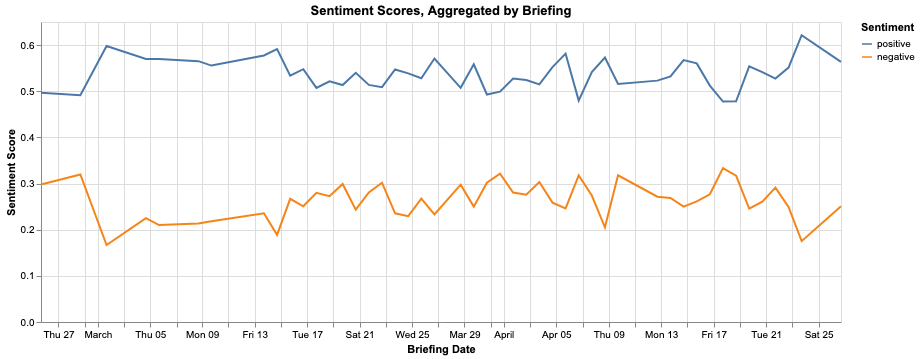

In [26]:
# prepare dataframe of aggregate sentiment scores by date for altair plotting
sentiment_by_date = texts_by_date_df[['positive', 'negative', 'date']]
sentiment_by_date = sentiment_by_date.melt(['date'], var_name='emo', value_name='score')

# plot aggregated scores
alt.Chart(sentiment_by_date).mark_line().encode(
    alt.X('date:T', axis=alt.Axis(title='Briefing Date', labelAngle=0)),
    alt.Y('score:Q', axis=alt.Axis(title='Sentiment Score')),
    alt.Color('emo:N', 
              legend=alt.Legend(title='Sentiment'), 
              sort=['positive'])
).properties(
    title = 'Sentiment Scores, Aggregated by Briefing',
    height = 300,
    width = 800
)

As far as emotional tone goes, we see consistently strong scores for 'trust' from briefing to briefing, with 'anticipation' and 'fear' being the next most prevalent:

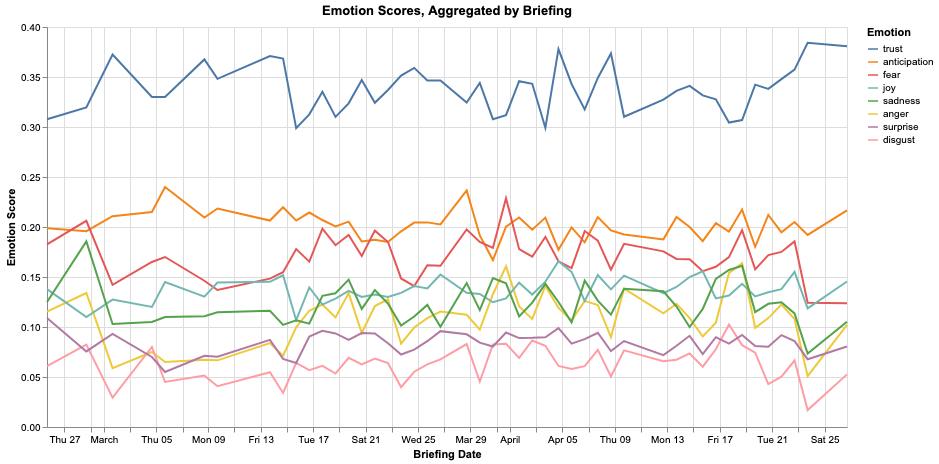

In [27]:
# prepare dataframe of aggregate emotion scores by date for altair plotting
emotion_by_date = texts_by_date_df.drop(columns=['positive', 'negative', 'pp_text'])
emotion_by_date = emotion_by_date.melt(['date'], var_name='emo', value_name='score')

# plot aggregated scores
alt.Chart(emotion_by_date).mark_line().encode(
    alt.X('date:T', axis=alt.Axis(title='Briefing Date', labelAngle=0)),
    alt.Y('score:Q', axis=alt.Axis(title='Emotion Score')),
    alt.Color('emo:N', 
              legend=alt.Legend(title='Emotion'),
              sort=['trust','anticipation','fear','joy','sadness','anger','surprise','disgust'])
).properties(    
    title = 'Emotion Scores, Aggregated by Briefing',
    height = 400,
    width = 800
)

#### What about emotion scores with respect to specific topics?

Looking at a heatmap showing aggregated fear scores with respect to each topic, on March 5th and 6th we note an increasingly fearful tone regarding the international spread of the virus. It's worth noting here that Vice President Pence had been the chair of the Task Force from February 26th up until these dates, with President Trump transitioning to be the point person in the days that followed.

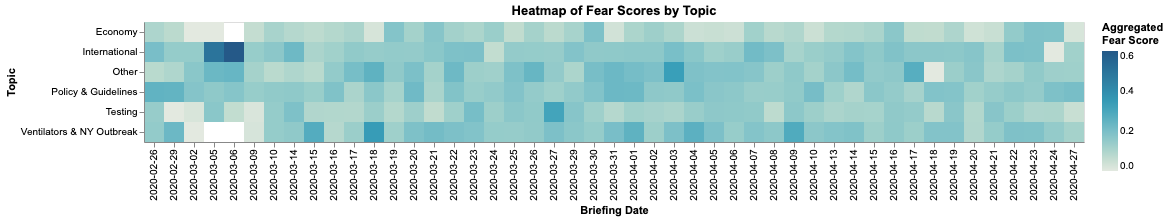

In [28]:
emo = 'fear'

topics_by_date = briefings_df.groupby(['topic_pred', 'date']).mean().reset_index()
topics_by_date = topics_by_date.melt(['topic_pred', 'date'], var_name='emo', value_name='score')

alt.Chart(topics_by_date[topics_by_date['emo'] == emo]).mark_rect().encode(  
    alt.X('date:O', axis=alt.Axis(title='Briefing Date')),
    alt.Y('topic_pred:N', axis=alt.Axis(title='Topic')),
    alt.Color('score:Q', 
              legend=alt.Legend(title=['Aggregated', emo.capitalize()+' Score']),
              scale=alt.Scale(scheme='lighttealblue'))
).properties(title = 'Heatmap of ' + emo.capitalize() + ' Scores by Topic')  

Interestingly we also see a more negative tone from Dr. Fauci during these early briefings, with a notable peak on March 6th:

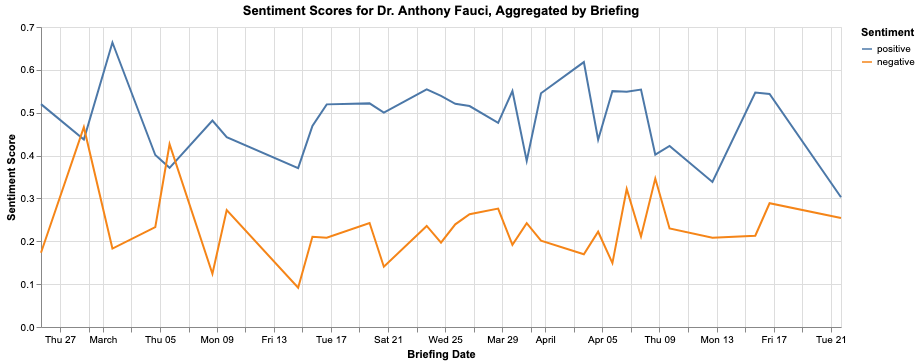

In [29]:
# prepare dataframe of aggregate sentiment scores by date for altair plotting
facui_df = briefings_df[briefings_df['speaker']=='Dr. Anthony Fauci']
fauci_by_date = facui_df.groupby(['date']).mean().reset_index()
sentiment_by_date = fauci_by_date[['positive', 'negative', 'date']]
sentiment_by_date = sentiment_by_date.melt(['date'], var_name='emo', value_name='score')

# plot aggregated scores
alt.Chart(sentiment_by_date).mark_line().encode(
    alt.X('date:T', axis=alt.Axis(title='Briefing Date', labelAngle=0)),
    alt.Y('score:Q', axis=alt.Axis(title='Sentiment Score')),
    alt.Color('emo:N', 
              legend=alt.Legend(title='Sentiment'), 
              sort=['positive'])
).properties(
    title = 'Sentiment Scores for Dr. Anthony Fauci, Aggregated by Briefing',
    height = 300,
    width = 800
)

#### Let's look at sentiment scores for some specific words

The scores we've calculated can also be used to compare the sentiment or emotion score for briefing texts containing specific words, as shown below for 'Hydroxychloroquine' and 'China':

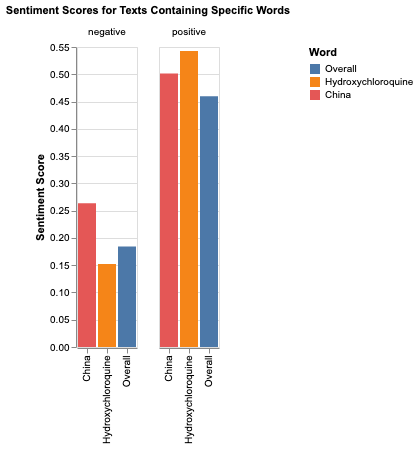

In [30]:
# prepare series of aggregate sentiment scores
overall_sentiments = briefings_df.mean()[['positive','negative']]
hydroxy_sentiments = briefings_df[briefings_df['text'].str.contains("droxy")].mean()[['positive','negative']]
china_sentiments = briefings_df[briefings_df['text'].str.contains("Chin")].mean()[['positive','negative']]

# merge series into a single df for plotting in altair
word_sentiments = pd.concat([overall_sentiments, hydroxy_sentiments, china_sentiments], axis=1).rename(columns={0: "Overall", 1: "Hydroxychloroquine", 2: "China"}).reset_index()
word_sentiments = word_sentiments.rename(columns={'index': "sentiment"})
word_sentiments = word_sentiments.melt(['sentiment'], var_name='word', value_name='score')

alt.Chart(word_sentiments).mark_bar().encode(
    alt.X('word:N', axis=alt.Axis(title='')),
    alt.Y('score:Q', axis=alt.Axis(title='Sentiment Score')),
    alt.Color('word:N', 
              legend=alt.Legend(title=['Word']),
              sort=['Overall','Hydroxychloroquine','China']),
    alt.Facet('sentiment:N', title='Sentiment Scores for Texts Containing Specific Words')
)

### Additional opportunities and final thoughts

While there's a lot more that could be done, I enjoyed using this as a way to apply some of the concepts I've been learning recently. 

I decided to consider the briefings as simple ordinal events, however a proper time series analysis could be done by aggregating briefing texts over a fixed date range (i.e by week, or five day increment), since there's some irregularity in when the briefings were held. I'd also be curious to look at how topics and emotions evolved over time in relation to other pandemic data such as case/death counts globally or within the US itself. 

Finally, it would be interesting to see how the White House briefings compared in tone with those delivered by Governor's [Andrew Cuomo of New York](https://www.rev.com/blog/transcript-tag/andrew-cuomo-transcripts) and [Gavin Newsom of California](https://www.rev.com/blog/transcript-tag/governor-gavin-newsom-transcripts), or [Canadian Prime Minister Justin Trudeau](https://www.rev.com/blog/transcript-tag/canada-coronavirus-briefing-transcripts) over the same timeframe. 